# Prerequisites
This section installs `gradslam` (if not already installed) and downloads the `lr kt1` (the first trajectory) of [ICL-NUIM dataset](https://www.doc.ic.ac.uk/~ahanda/VaFRIC/iclnuim.html) and structures it as below:
```
ICL
    living_room_traj1_frei_png
        depth/    rgb/    associations.txt    livingRoom1.gt.freiburg    livingRoom1n.gt.sim
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# install gradslam (if not installed)
try:
    import gradslam as gs
except ImportError:
    print("Installing gradslam...")
    !pip install 'git+https://github.com/gradslam/gradslam.git' -q
    print('Installed')

# download 'lr kt1' of ICL dataset
if not os.path.isdir('/content/drive/MyDrive/GRADSLAM/ICL'):
    os.mkdir('/content/drive/MyDrive/GRADSLAM/ICL')
if not os.path.isdir('/content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png'):
    print('Downloading ICL/living_room_traj1_frei_png dataset...')
    os.mkdir('/content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png')
    !wget http://www.doc.ic.ac.uk/~ahanda/living_room_traj1_frei_png.tar.gz -P /content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png/ -q
    !tar -xzf /content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz -C /content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png/
    !rm /content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png/living_room_traj1_frei_png.tar.gz
    !wget https://www.doc.ic.ac.uk/~ahanda/VaFRIC/livingRoom1n.gt.sim -P /content/drive/MyDrive/GRADSLAM/ICL/living_room_traj1_frei_png/ -q
    print('Downloaded.')
icl_path = '/content/drive/MyDrive/GRADSLAM/ICL/'

Installing gradslam...
     |████████████████████████████████| 225kB 11.0MB/s 
     |████████████████████████████████| 13.2MB 250kB/s 
     |████████████████████████████████| 4.6MB 55.9MB/s 
     |████████████████████████████████| 37.6MB 147kB/s 
Installed


In [ ]:
!curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
!tar xzf 1.10.0.tar.gz
os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118    0   118    0     0    737      0 --:--:-- --:--:-- --:--:--   737
100  404k    0  404k    0     0   848k      0 --:--:-- --:--:-- --:--:--  848k


In [ ]:
pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-79hc2ush
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-79hc2ush
     |████████████████████████████████| 276kB 13.7MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20571559 sha256=0719086871f67e4a9a8335de188af728d82a867c8d2ade4ae801bc642335e63c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xu2nxanc/wheels/43/ba/81/3e4acb84fba48ba1b8264b1e4bba60662d098cb0c7cf486723
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210115-cp36-none-any.whl size=40892 sha256=a173edfc7e2f81dff20862a91908a12b36b03ed72e4664c6702fdefca065012c
  Stored in directory: /root/.cache/pip/wheels/cc/0f/bc/fb742771f4a877f1211dd6ed36283b0db9c0ceb2b409b4a039
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=d3dcf14c36b50425b7c044ff5251d25956eb35430964257429688cb8d1137e72
  Stored in directory: /ro

# Imports

In [ ]:
import cv2
import gradslam as gs
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from chamferdist.chamfer import knn_points
from gradslam import Pointclouds, RGBDImages
from gradslam.datasets import ICL
from gradslam.slam import PointFusion
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Load Dataset
Load the first 4 frames of `icl/living_room_traj1_frei_png`, store them in `rgbdimages`, and visualize them.


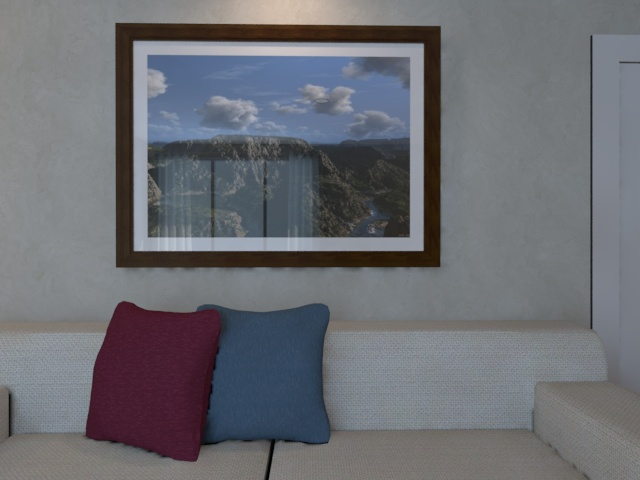
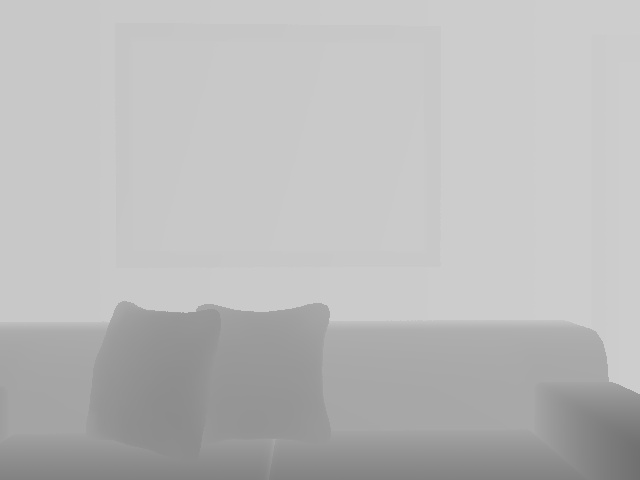
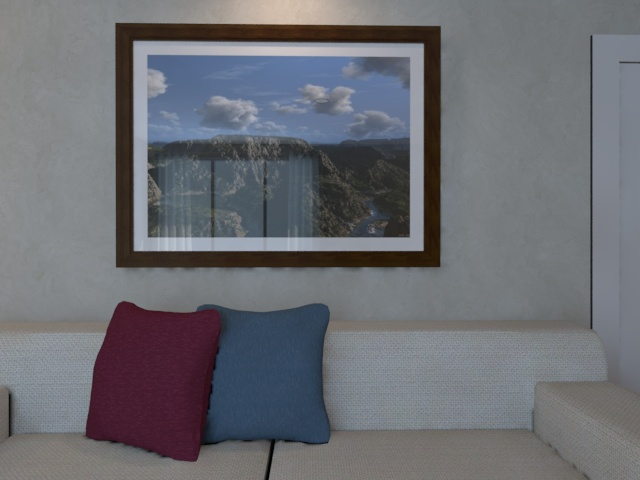
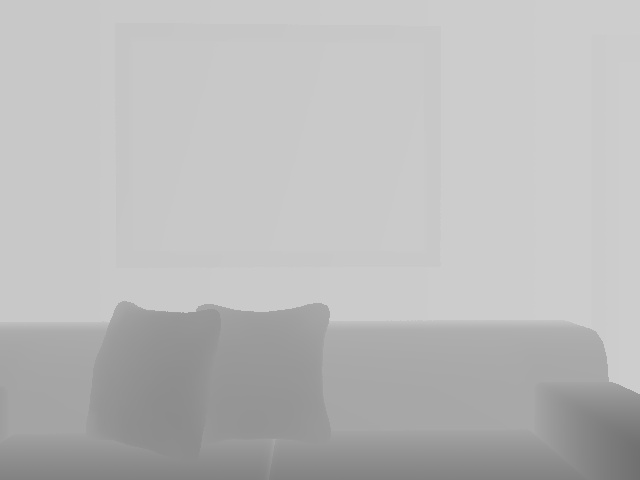
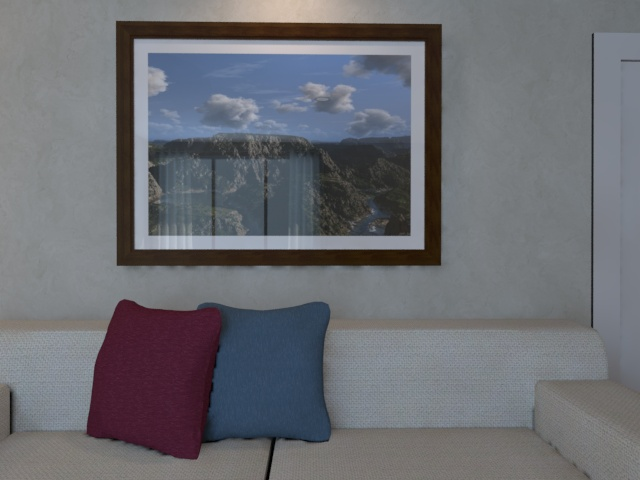
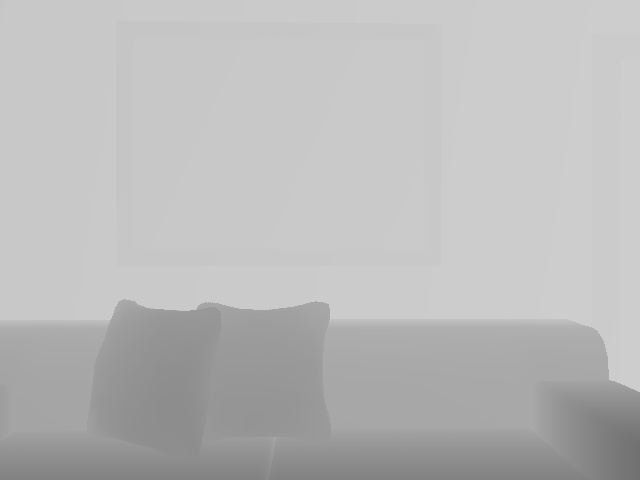
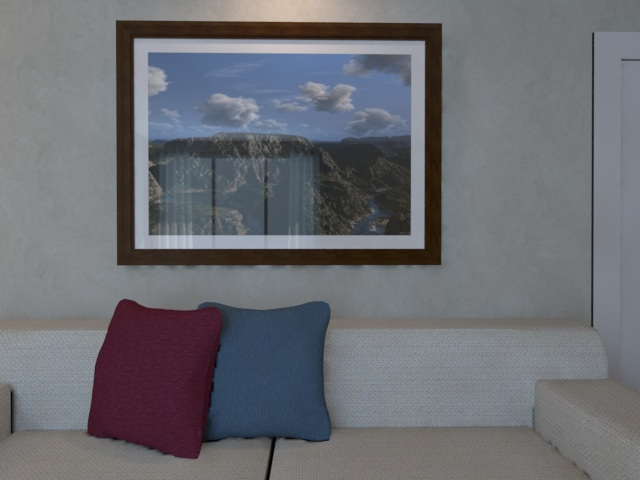
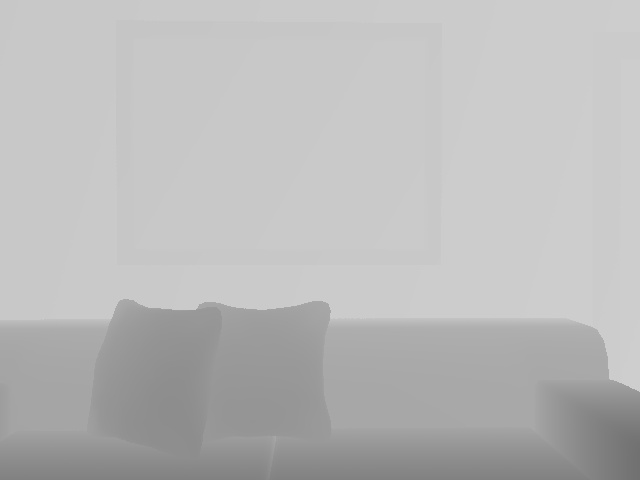
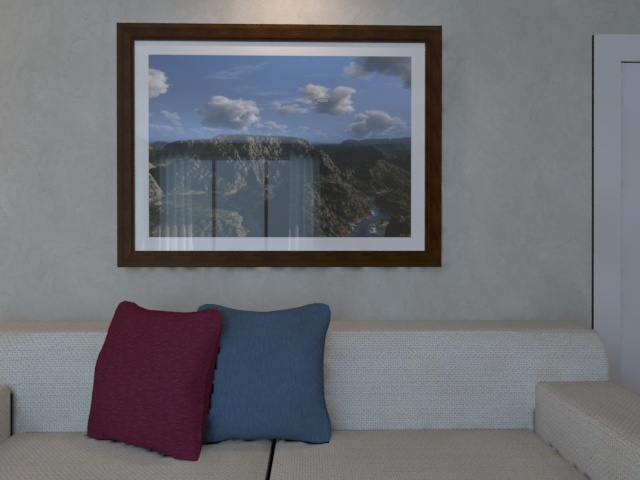
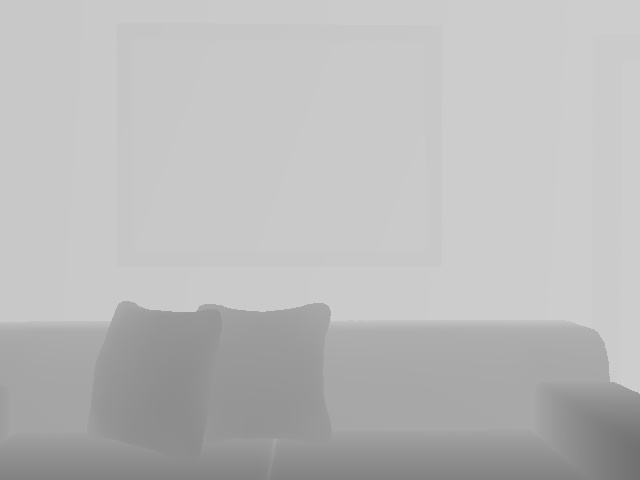

In [ ]:
# load dataset
dataset = ICL(icl_path, seqlen=4, height=480, width=640)
loader = DataLoader(dataset=dataset, batch_size=1)
colors, depths, intrinsics, poses, *_ = next(iter(loader))
colors /= 255

# create rgbdimages object
rgbdimages = RGBDImages(colors, depths, intrinsics, poses)
rgbdimages.plotly(0).update_layout(autosize=False, height=600, width=400).show()

# Groundtruth Reconstruction

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
slam = PointFusion(device=device, odom="gt")
gt_global_map, _ = slam(rgbdimages)
#gt_global_map.plotly(0).show()

# Corrupted Reconstruction


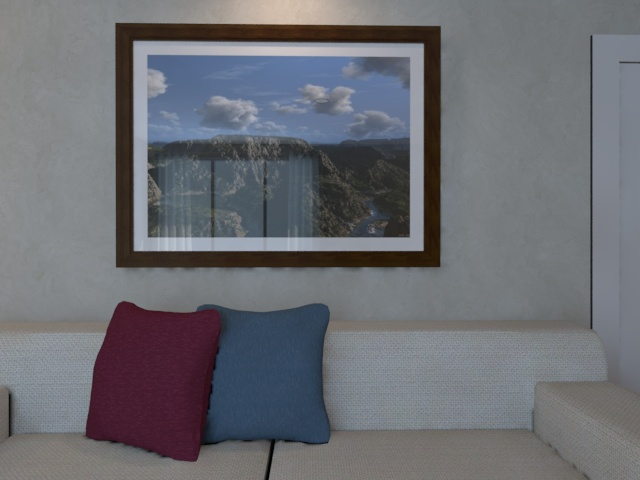
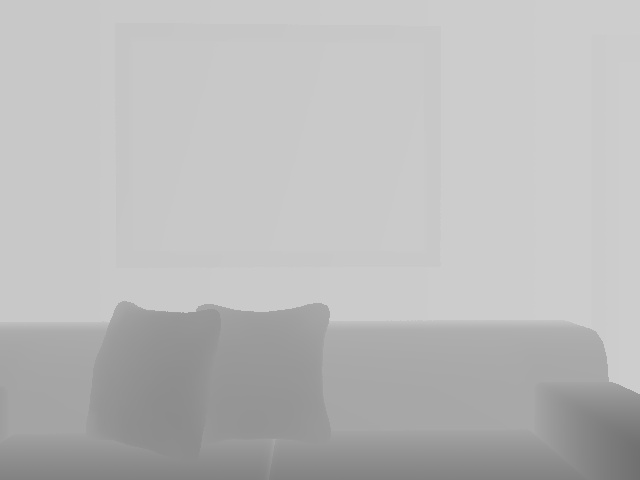
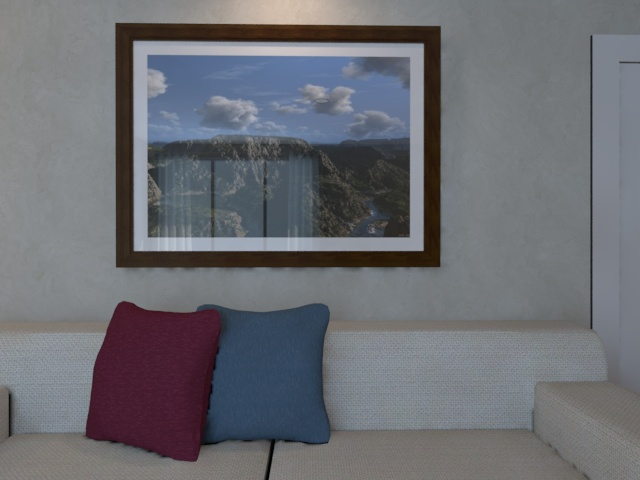
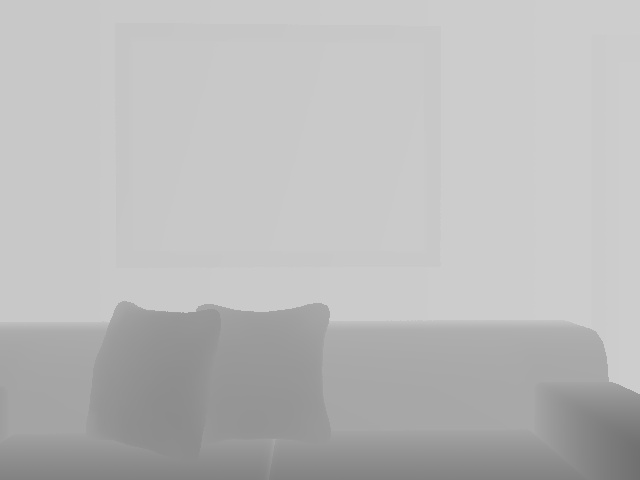
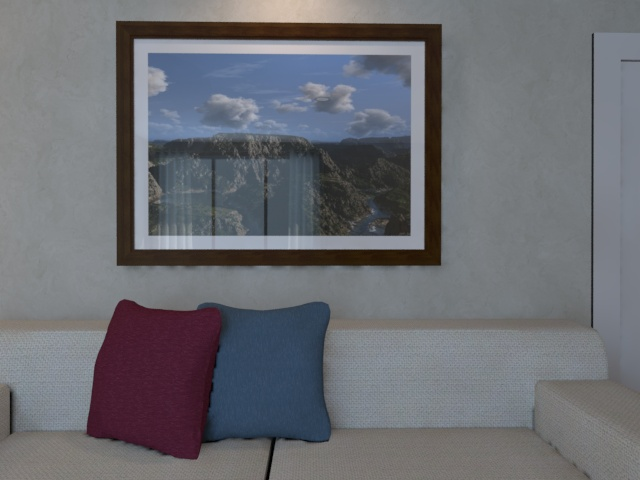
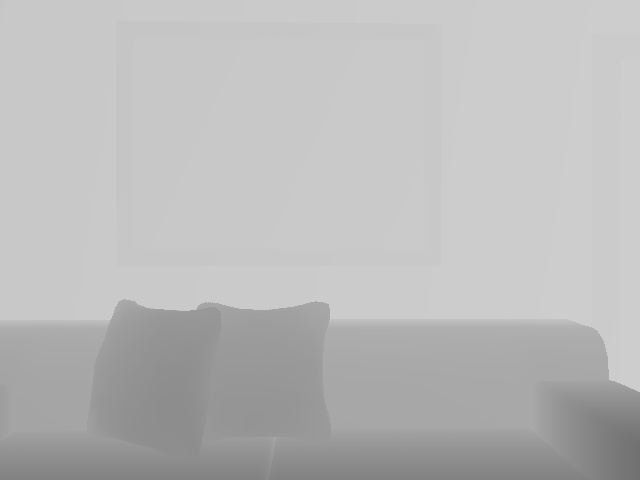
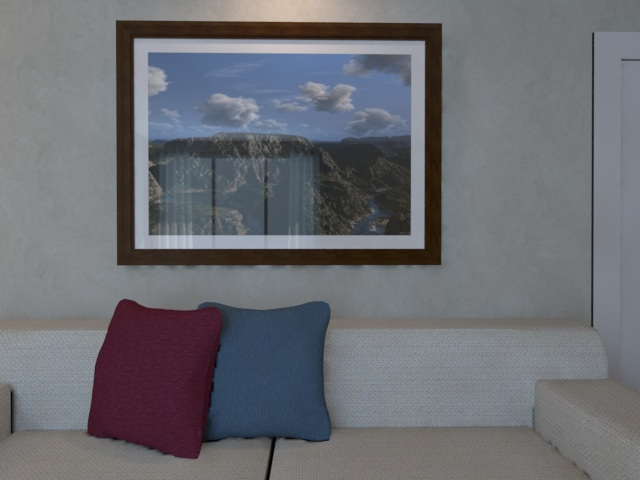
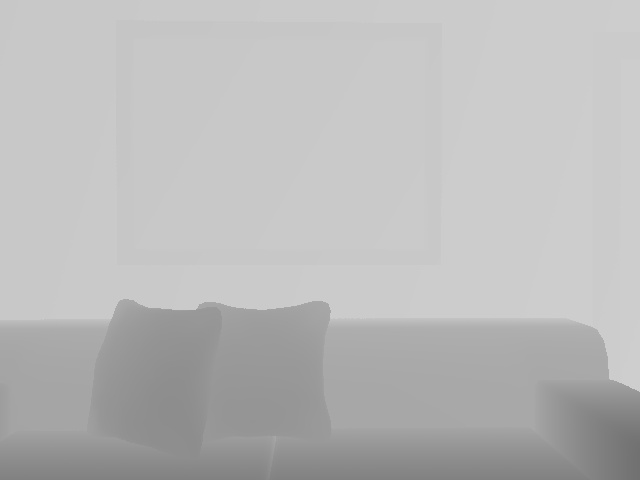
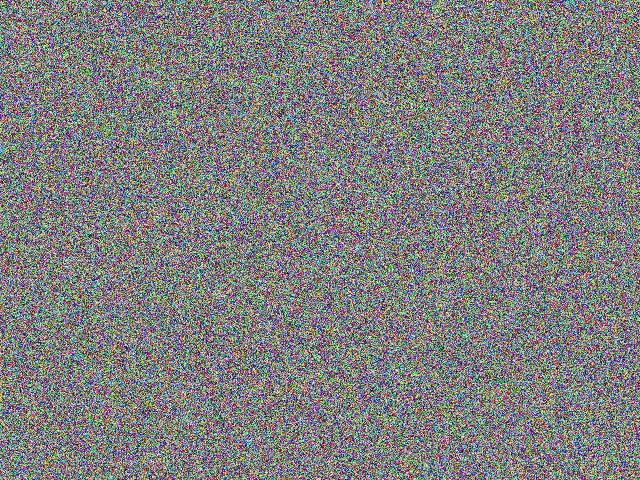
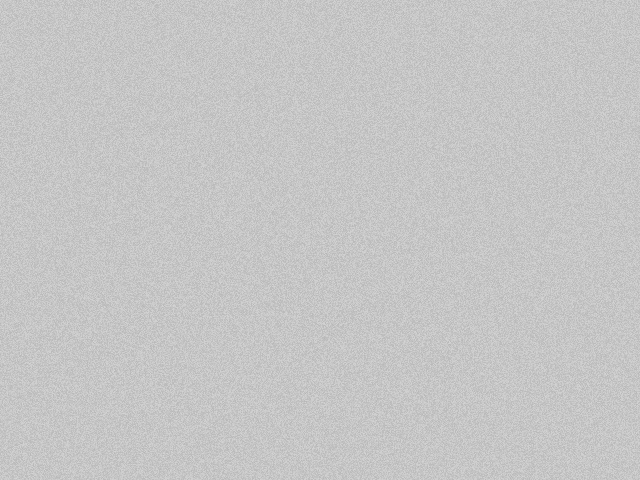

In [ ]:
def get_corrupted_rgbdimages():
    pert_depths = depths.clone()
    pert_colors = colors.clone()

    mu = torch.mean(pert_depths)
    std = torch.std(pert_depths)

    #noise_rgb = 0.2*torch.rand((1,1,480,640,3))
    #noise_depth = 0.1*torch.randn((1,1,480,640,1))
    pert_depths[:, -1, ...] = (torch.rand(1, 480, 640, 1).to(device) * std) + mu
    pert_colors[:, -1, ...] = torch.rand(1, 480, 640, 3).to(device)
    #pert_depths[:, -1, ...] = torch.add(pert_depths[:, -1, ...], noise_depth)
    #pert_colors[:, -1, ...] = torch.add(pert_colors[:, -1, ...], noise_rgb)

    # Turn requires_grad on for colors/depths
    pert_depths.requires_grad_().retain_grad()
    pert_colors.requires_grad_().retain_grad()

    return RGBDImages(pert_colors, pert_depths, intrinsics, poses)

pert_rgbdimages = get_corrupted_rgbdimages()
pert_rgbdimages.plotly(0).update_layout(autosize=False, height=600, width=400).show()
#slam(pert_rgbdimages)[0].plotly(0).show()

In [ ]:
from pytorch3d.structures import Pointclouds as pc
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras,
    PerspectiveCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
)

K = intrinsics[0]
C = poses[0][3]
R = C[:3,:3].view(1,3,3).to(device)
T = C[:3,-1:].view(1,3).to(device)

cameras = PerspectiveCameras(device=device, 
                             R=R, T=T,
                             focal_length=((-480.00, 481.20),),
                             principal_point=((319.50, 239.50),), 
                             image_size=((640,480),))
raster_settings = PointsRasterizationSettings(
    image_size=(480,640), 
    radius = 0.004,
    points_per_pixel = 50
)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=NormWeightedCompositor(background_color=(0, 0, 0))
)

# Optimize Input

In [ ]:
def get_rendered_img(pert_cloud):
    verts = pert_cloud.points_list[0].to(device)
    rgb = (pert_cloud.colors_list[0]).to(device)

    point_cloud = pc(points=[verts], features=[rgb])
    image = renderer(point_cloud)
    return image


In [ ]:
def compute_error(pred, gt):
  error=torch.sqrt(torch.nn.functional.mse_loss(pred,gt))
  print("RMSE between perturbed and gt depth : {:.4f}".format(error))


In [ ]:
if os.path.exists('images'):
    shutil.rmtree('images')
os.mkdir('images')

def convert_seq_to_one(image_tensor, denormalize=False, SCHW=True):
    r"""Converts sequence of images into one image for visualization
    Args:
        image_tensor (torch.Tensor): (of shape: [S, C, H, W] OR [S, H, W, C])
        denormalize (bool, Optional): If ``True``, will multiply image_tensor
                                      values by 255.
    """
    if SCHW:
        seq_len, C, H, W = image_tensor.shape
        image_tensor = image_tensor.permute(2, 0, 3, 1).contiguous()
    else:
        seq_len, H, W, C = image_tensor.shape
        image_tensor = image_tensor.permute(1, 0, 2, 3).contiguous()
        
    if denormalize:
        image_tensor = image_tensor * 255
    
    image_tensor = image_tensor.view(H, -1, C)
    image = image_tensor.detach().cpu().numpy().astype(np.uint8)
    return image

def custom_slam(rgbdimages):
    r"""
    Performs SLAM on the sequence of frames in the input rgbdimages.
    Keeps gradients on for the final frame, and detaches the gradients
    for all previous frames in the sequence (as they were uncorrupted 
    ground truth frames)
    """
    pointclouds = Pointclouds(device=device)
    batch_size, seq_len = rgbdimages.shape[:2]
    initial_poses = torch.eye(4, device=device).view(1, 1, 4, 4).repeat(batch_size, 1, 1, 1)
    prev_frame = None
    for s in range(seq_len):
        live_frame = rgbdimages[:, s].to(device)
        live_frame = live_frame.detach() if s < seq_len - 1 else live_frame
        if s == 0 and live_frame.poses is None:
            live_frame.poses = initial_poses
        pointclouds, live_frame.poses = slam.step(pointclouds, live_frame)
        live_frame.poses = live_frame.poses.detach()
    return pointclouds


def loss_fn(pert_cloud, gt_rgb_image):
    rendered_img = get_rendered_img(pert_cloud)
    return torch.nn.functional.mse_loss(rendered_img, gt_rgb_img)


RMSE between perturbed and gt depth : 0.2707
RMSE between perturbed and gt depth : 0.1313


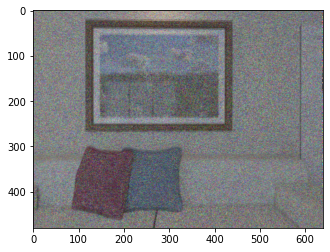

In [ ]:
pert_rgbdimages = get_corrupted_rgbdimages()
pert_depths = pert_rgbdimages.depth_image
pert_colors = pert_rgbdimages.rgb_image
lr = 5e-2

optimizer = torch.optim.Adam([pert_depths, pert_colors], lr=lr)
gt_rgb_img = colors[0][3].unsqueeze(0).contiguous().detach().to(device)

pert_global_map = slam(pert_rgbdimages)
#pert_global_map[0].plotly(0).show()

img = get_rendered_img(pert_global_map[0])
plt.imshow(img[0].detach().cpu().numpy())

compute_error(pert_depths[0][3],depths[0][3])
compute_error(pert_depths[0][3]/ torch.max(depths),depths[0][3]/ torch.max(depths))

In [ ]:
for i in tqdm(range(150), desc='train'):
    pert_global_map = custom_slam(pert_rgbdimages)
    loss = loss_fn(pert_global_map, gt_rgb_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # save rgbdimages visualization
    rgb_image = convert_seq_to_one(pert_colors[0], True, SCHW=False)
    depth_image = convert_seq_to_one(pert_depths[0].repeat(1,1,1,3) / torch.max(depths), True, SCHW=False)
    image = np.concatenate([rgb_image, depth_image], 0)
    imageio.imwrite(os.path.join(f'images/{i:03d}.jpg'), image)

    if i % 10 == 0:
        #tqdm.write("Cloud Loss {:.6f}, Color Loss {:.6f}".format(cloud_loss, color_loss))
        tqdm.write("Loss {:.6f}".format(loss))

Loss 0.012857
Loss 0.001218
Loss 0.000566
Loss 0.000237
Loss 0.000127
Loss 0.000084
Loss 0.000068
Loss 0.000061
Loss 0.000057
Loss 0.000055
Loss 0.000053
Loss 0.000053
Loss 0.000052
Loss 0.000052
Loss 0.000051



# Convert result to video and show

In [ ]:
! ffmpeg -loglevel panic -framerate 10 -i images/%03d.jpg -c:v libx264 -pix_fmt yuv420p optimization_video.mp4

File 'optimization_video.mp4' already exists. Overwrite ? [y/N] y


In [ ]:
# https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab

from IPython.display import HTML
from base64 import b64encode
mp4 = open('optimization_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=800 controls> <source src="%s" type="video/mp4"> </video>""" % data_url)

In [ ]:
compute_error(pert_depths[0][3],depths[0][3])
compute_error(pert_depths[0][3]/ torch.max(depths),depths[0][3]/ torch.max(depths))

RMSE between perturbed and gt depth : 0.4368
RMSE between perturbed and gt depth : 0.2118


In [ ]:
(pert_depths).max()

tensor(3.3216, grad_fn=<MaxBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


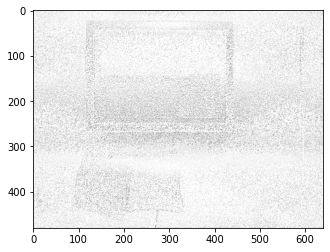

In [ ]:
plt.imshow((pert_depths[0][3].repeat(1,1,3)/ torch.max(depths)).detach().cpu().numpy())

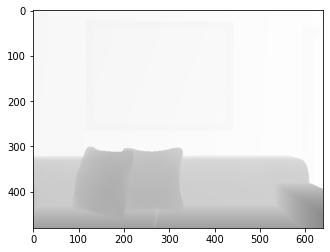

In [ ]:
plt.imshow((depths[0][3].repeat(1,1,3)/ torch.max(depths)).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


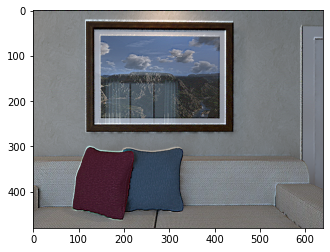

In [ ]:
plt.imshow((pert_colors[0][3]).detach().cpu().numpy())